In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import cartopy.crs as ccrs
import cartopy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from config import PATH_CLUSTERS, VERSION, PATH_ED_REGIONS, ED_FILENAME_REGIONS
import utils as ut
import xarray as xr


In [45]:
df_wr = pd.read_csv(cluster_path)
df_wr

,time,run,Bayes_cluster,Bayes_cluster_raw,raw_cluster_id,prior,likelihood,posterior,wri
0,2000-01-01 09:00:00,10,3,3,3,"[0.25038417052214146, 0.25231741573033706, 0.2...","[0.0004263262033320425, 5.26270358938893e-12, ...","[0.0005116830771693936, 6.365144922866484e-12,...","[0.2348302082399062, -1.8370989310343502, 0.39..."
1,2000-01-02 09:00:00,10,3,3,3,"[0.08461802024378669, 0.06450377392647698, 0.0...","[0.0004993483362468188, 5.403607438791499e-10,...","[5.877147604899073e-05, 4.8480718359163145e-11...","[0.21628709309448363, -1.2645198260384203, -0...."
2,2000-01-03 09:00:00,10,3,3,3,"[0.08429949324247622, 0.06451732594471449, 0.0...","[0.00015782056298803816, 3.5364179116316807e-0...","[1.8483719071152796e-05, 3.1698648594750197e-0...","[-0.01883416604091077, -0.7701444570901014, -0..."
3,2000-01-04 09:00:00,10,3,3,3,"[0.08427111807842859, 0.06451761187570079, 0.0...","[0.016211559329013754, 6.731323560236407e-07, ...","[0.0019252645845668145, 6.120200164390866e-08,...","[0.4171941616968025, -0.6349194760272813, -0.8..."
4,2000-01-05 09:00:00,10,3,3,3,"[0.08561409840888319, 0.06450467119456459, 0.0...","[0.04703785247839493, 4.616709996432851e-07, 3...","[0.005845518199970246, 4.3226891331070784e-08,...","[0.5467612865805082, -0.7151075080287698, -0.7..."
...,...,...,...,...,...,...,...,...,...
242075,2009-12-27 09:00:00,169,2,2,2,"[0.7834063924613388, 0.057615127281289084, 0.1...","[0.021542216567772502, 3.2886043873867774e-07,...","[0.13004396448347105, 1.460026907602867e-07, 0...","[0.5485543067007072, -1.0311588565227428, 1.34..."
242076,2009-12-28 09:00:00,169,2,2,2,"[0.17508680597750956, 0.04652761999519657, 0.6...","[0.00023222674100806576, 5.802402387291438e-08...","[5.983832137785964e-05, 3.973126889020857e-09,...","[0.058541493065220614, -1.1612206110393928, 1...."
242077,2009-12-29 09:00:00,169,2,2,2,"[0.08342233750044936, 0.04485659684716104, 0.7...","[2.470746860061014e-05, 1.0053391874001083e-08...","[2.7075254135424806e-06, 5.923806555956097e-10...","[-0.24712583873052343, -1.321208912863901, 1.7..."
242078,2009-12-30 09:00:00,169,2,2,2,"[0.08338273333133037, 0.04487118218292615, 0.7...","[4.492419935755291e-06, 9.938626731487292e-09,...","[5.211668475225122e-07, 6.204605877971423e-10,...","[-0.5433309834214252, -1.3364474914470685, 1.6..."


In [49]:
cluster_path = PATH_CLUSTERS + VERSION + '/df_clusters_full_ordered.csv'
df_wr = pd.read_csv(cluster_path)
df_wr = df_wr[['time', 'run', 'Bayes_cluster', 'posterior', 'wri']]
df_wr['time'] = pd.to_datetime(df_wr['time'])
df_wr['time'] = df_wr['time'].apply(lambda dt: dt.replace(hour=12, minute=0, second=0)) # set time to noon, to match df. Is daily average anyway

ed = pd.read_csv(os.path.join(PATH_ED_REGIONS, ED_FILENAME_REGIONS)).reset_index(drop=True)
ed['run'] = ed['runs'].str.extract('(\d+)').astype(int)
df_events = ed.drop(['Unnamed: 0', 'runs'], axis = 1)

def find_dominant_wr(df_events, df_wr, cluster_col):
    df_events['weather_regime_ids'] = None
    df_events['dominant_weather_regime'] = None

    # Iterate over the rows of overlapping_events_df
    for index, row in df_events.iterrows():
        run_condition = (df_wr['run'] == row['run'])
        date_condition = (df_wr['time'] >= row['start_time']) & (df_wr['time'] <= row['end_time'])
        
        # Filter df_wr based on run and date conditions
        relevant_weather_regimes = df_wr[run_condition & date_condition][cluster_col].tolist()
        
        dominant_2 = Counter(relevant_weather_regimes).most_common(2)
        if len(dominant_2) == 1:
            df_events.at[index, 'dominant_weather_regime'] = dominant_2[0][0]
        elif len(dominant_2) > 1:
            if dominant_2[0][1] - dominant_2[1][1] > 1: # if one regime occurs at least two days more
                df_events.at[index, 'dominant_weather_regime'] = dominant_2[0][0]
            elif dominant_2[0][1] - dominant_2[1][1] <= 1:
                df_events.at[index, 'dominant_weather_regime'] = 5 # no persisting regime #[dominant_2[0][0], dominant_2[1][0]]
        # Update the 'weather_regime_ids' column in overlapping_events_df
        df_events.at[index, 'weather_regime_ids'] = relevant_weather_regimes
        df_events.at[index, 'wri_dominant'] = row['wri'][dominant_2][0][0]
    return df_events

df_event_wr = find_dominant_wr(df_events, df_wr, cluster_col = 'Bayes_cluster')

KeyError: 'wri'

In [47]:
N_event_blocking = df_event_wr.query('country == "N" and dominant_weather_regime == 2').sort_values(by =  'run')

In [48]:
N_event_blocking

,event_number,start_time,end_time,country,run,weather_regime_ids,dominant_weather_regime
4443,1244,2007-12-31 12:00:00,2008-01-06 12:00:00,N,10,"[3, 2, 2, 2, 2, 2, 2]",2
3311,112,2009-02-23 12:00:00,2009-03-01 12:00:00,N,13,"[2, 2, 2, 2, 2, 4, 4]",2
4296,1097,2000-02-01 12:00:00,2000-02-07 12:00:00,N,19,"[4, 4, 2, 2, 2, 2, 2]",2
4261,1062,2006-01-07 12:00:00,2006-01-13 12:00:00,N,25,"[2, 2, 2, 2, 2, 1, 1]",2
4438,1239,2006-01-17 12:00:00,2006-01-23 12:00:00,N,30,"[3, 3, 2, 2, 2, 2, 4]",2
...,...,...,...,...,...,...,...
4688,1489,2001-03-08 12:00:00,2001-03-14 12:00:00,N,158,"[2, 2, 2, 2, 2, 2, 2]",2
4337,1138,2001-02-24 12:00:00,2001-03-02 12:00:00,N,158,"[4, 2, 2, 2, 2, 4, 1]",2
4605,1406,2001-01-01 12:00:00,2001-01-07 12:00:00,N,162,"[2, 2, 2, 2, 2, 2, 2]",2
4227,1028,2006-01-15 12:00:00,2006-01-21 12:00:00,N,167,"[2, 2, 2, 2, 2, 2, 2]",2


In [41]:
N_event_blocking.sort_values(by = 'run')
N_event_blocking['start_time'] = pd.to_datetime(N_event_blocking['start_time'])
N_event_blocking['end_time'] = pd.to_datetime(N_event_blocking['end_time'])

In [42]:
ANOM_PATH = '/net/pc230050/nobackup/users/duinen/LENTIS/present/'
PSL_PATH = '/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d/'
tas_sel = []
wind_sel = []
psl_sel = []

for index, row in N_event_blocking.iterrows():
    run = row['run']
    start_time = row['start_time']
    tas_run = xr.open_dataset(f"{ANOM_PATH}tas_d_anomaly/anom_tas_d_ECEarth3_h{run:03}.nc")["tas"]
    wind_run = xr.open_dataset(f"{ANOM_PATH}sfcWind_d_anomaly/anom_sfcWind_d_ECEarth3_h{run:03}.nc")["sfcWind"]
    psl_run = xr.open_dataset(f"{PSL_PATH}psl_d_ECEarth3_h{run:03}.nc")["psl"]
    tas_sel.append(tas_run.sel(time = slice(start_time, start_time + pd.Timedelta(days = 6))))
    wind_sel.append(wind_run.sel(time = slice(start_time, start_time + pd.Timedelta(days = 6))))
    psl_sel.append(psl_run.sel(time = slice(start_time, start_time + pd.Timedelta(days = 6))))

In [43]:
tas_composite = xr.concat(tas_sel, dim = 'time').mean(dim = "time")
wind_composite = xr.concat(wind_sel, dim = 'time').mean(dim = "time")
psl_composite = xr.concat(psl_sel, dim = 'time').mean(dim = "time") / 100

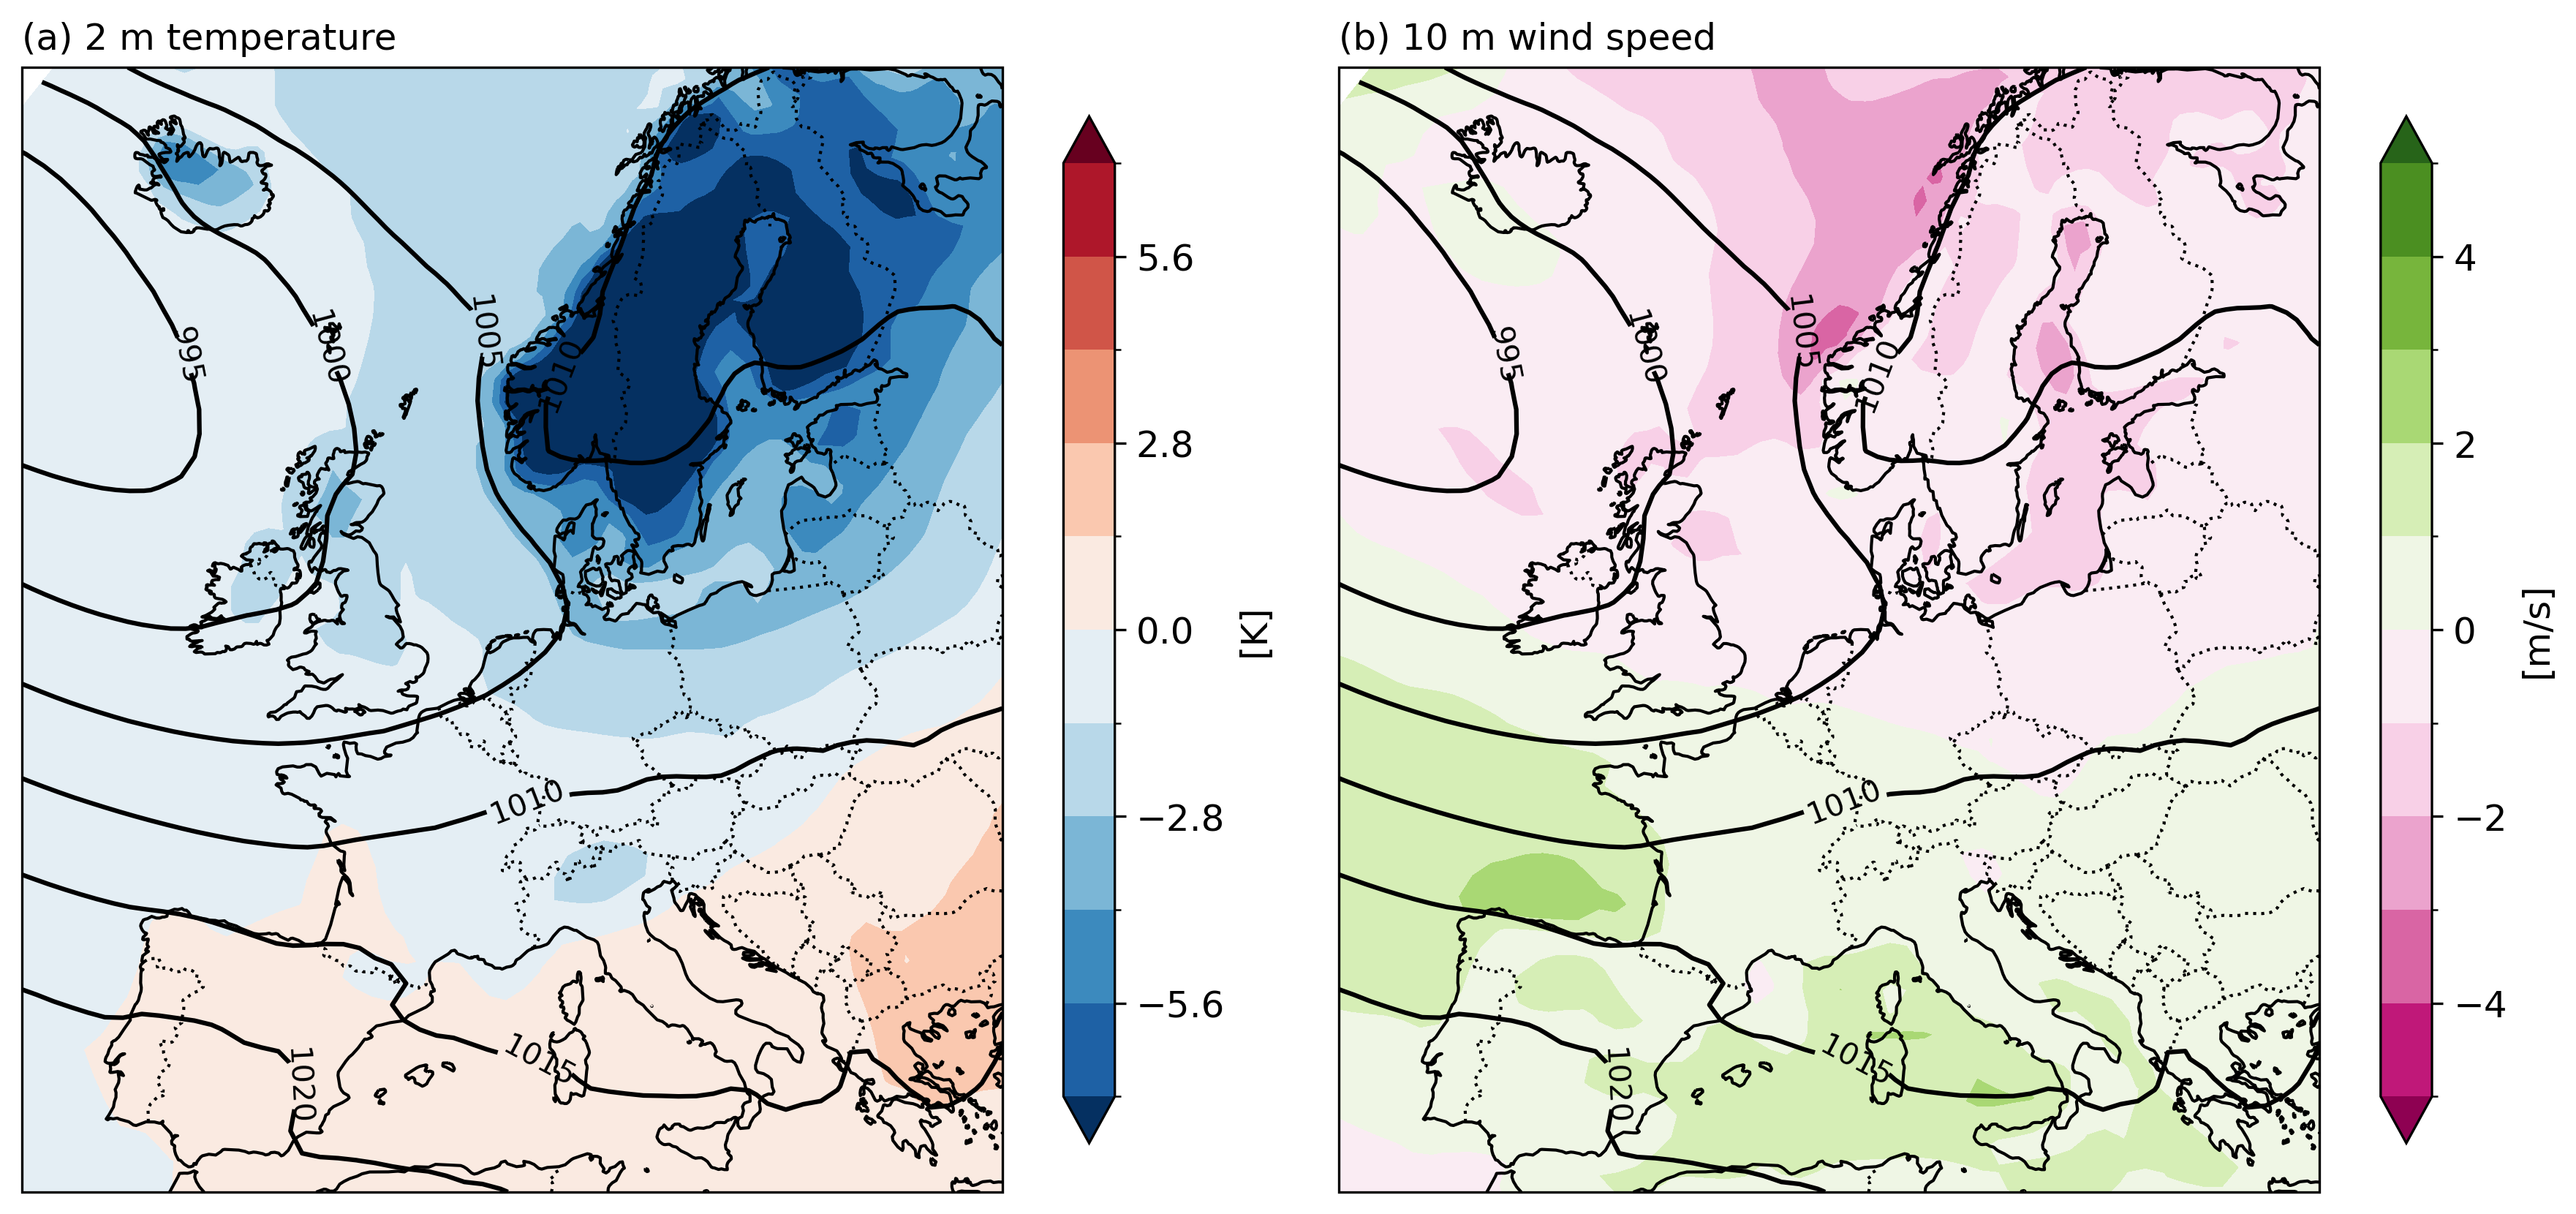

In [44]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(12, 12),
    subplot_kw={"projection": ccrs.EuroPP()},
    dpi=300,
)
fontsize = 12
# fig.subplots_adjust(hspace=0.15, wspace=0.1, top=0.95, bottom=0.1, left=0.05, right=0.95)

vmin_list = [-7, -5]
vmax_list = [7, 5]
titles = ["(a) 2 m temperature", "(b) 10 m wind speed"]
cmaps = [plt.cm.RdBu_r, plt.cm.PiYG]
cbar_units = ["[K]", "[m/s]"]

lons, lats = psl_composite.lon, psl_composite.lat
data_meteo = [tas_composite, wind_composite]

for j in range(2):
    ax = axs[j]
    data = data_meteo[j]
    psl = psl_composite

    levels = np.linspace(vmin_list[j], vmax_list[j], 11)
    norm = colors.BoundaryNorm(levels, ncolors=cmaps[j].N, extend="both")
    im = ax.contourf(
        lons,
        lats,
        data,
        transform=ccrs.PlateCarree(),
        levels=levels,
        cmap=cmaps[j],
        norm=norm,
        extend="both",
    )
    CS = ax.contour(
        lons,
        lats,
        psl,
        transform=ccrs.PlateCarree(),
        colors="k",
    )

    ax.clabel(CS, inline=True, fontsize=10)

    ax.set_extent([-30, 33, 35, 70], crs=ccrs.PlateCarree())
    # )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1)

    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.4)
    cbar.set_label(cbar_units[j], fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    ax.set_title(titles[j], fontsize=fontsize, loc = "left")
plt.tight_layout()